<h1>Segmenting and Clustering Neighborhoods in Toronto</h1>

<h3> Part 1: Create the dataframe with the needed data </h3>

In [7]:
#Importing libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
print("Libraries imported!")

Libraries imported!


In [10]:
#First lets download the page
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
if page.status_code == 200:
    print('Page downloaded successfuly!')
else:
    print('Page could not be downloaded');

Page downloaded successfuly!


In [23]:
#Lets acces the webpage and create the dataframe
soup = BeautifulSoup(page.content, 'html.parser');
#Checking the code of the webpage, we can see it's a 'table' tag, in particular with the class 'wikitable sortable'
tdata = soup.find_all('table', class_='wikitable sortable');
#Let's make sure that's the only table available and we didn't extract uneeded tables.
if len(tdata) == 1:
    print('Table found!');
else:
    print('More than one table has been found');

Table found!


In [105]:
    #Since that is the only table in the webpage with that tag and class, we can proceed to parse it as dataframe:
    df = pd.read_html(str(tdata))[0];

In [106]:
#Lets process the table as indicated in the exercise
#First, let's delete the rows where the Bourough is 'Not assigned'
df.drop(df[df.Borough =='Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True);
print('Rows with unassigned Boroughs have been deleted!')
#Let's assign the 'Not assigned' neighbourhoods where the Borough is informed
df['Neighbourhood'] = np.where(df['Neighbourhood'] == 'Not assigned', df['Borough'], df['Neighbourhood']);
print('Unassigned Neighbourhoods have been assigned their Borough!')
#Last, let's check which postal codes have been duplicated by having multiple neighbourhoods, pertaining to the same borough:
df_grpd = df.groupby(['Postal Code', 'Borough']).count(); #We group the dataframe by postal code and borough, count the rows
df_grpd_dupl = df_grpd[df_grpd['Neighbourhood'] > 1]; #We look for those cases where count > 1
if df_grpd_dupl.shape[0] > 0:
    print('There are duplicates!')
else:
    print('There are not any duplicates!')
df.head()

Rows with unassigned Boroughs have been deleted!
Unassigned Neighbourhoods have been assigned their Borough!
There are not any duplicates!


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [107]:
#Once the table has been processed, we can calculate the number of rows:
print('The number of rows in our dataframe is', df.shape[0])

The number of rows in our dataframe is 103


<h3> Part 2: Obtain the coordinates of the neighbourhoods: </h3>

In [101]:
#So apparently I could not import the geocoder onto here
#Therefore,I will just join the provided .csv to our dataframe
postal_codes = pd.read_csv('https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv')

In [108]:
#Now we are just gonna join our dataframe to the postal codes:
df = pd.merge(df, postal_codes, on='Postal Code', how='left');
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


<h3> Part 3: Clustering the neighborhoods </h3>
<h5> First we extract the boroughs pertaining to Toronto </h5>

In [124]:
#We first extract the boroughs pertaining to Toronto:
df_Toronto = df[df['Borough'].str.contains('Toronto', regex=False)];
df_Toronto.reset_index(drop=True, inplace=True);
print('There are', df_Toronto.shape[0], ' different postal codes pertaining to Toronto Boroughs')

There are 39  different postal codes pertaining to Toronto Boroughs


<h5>Then, we define the Foursquare credentials and write a function to obtain the categories of the top 100 venues in a radius of 500m </h5>

In [127]:
#Define Foursquare credentials
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210101' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500;
# Credentials deleted before uploading

In [131]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [132]:
toronto_venues = getNearbyVenues(names=df_Toronto['Neighbourhood'], latitudes=df_Toronto['Latitude'], longitudes=df_Toronto['Longitude']);

<h5>We can check how many venues did we obtain data from and how many venues per neighbourhood did we obtain</h5>

In [144]:
print('The code returned', toronto_venues.shape[0],' venues!');
print('There are {} uniques categories!'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues[['Neighborhood', 'Venue']].groupby('Neighborhood').count()

The code returned 1624  venues!
There are 235 uniques categories!


,Venue
Neighborhood,
Berczy Park,58
"Brockton, Parkdale Village, Exhibition Place",22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16
Central Bay Street,65
Christie,16
Church and Wellesley,79
"Commerce Court, Victoria Hotel",100
Davisville,38


<h5> Now let's create the new dataframe and display the frequency of occurrence in each neighbourhood

In [148]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,"Business reply mail Processing Centre, South C...",0.058824,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,Central Bay Street,0.015385,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.015385,0.0,0.0,0.015385,0.0


<h5>Now let's create the new dataframe and display the top 10 venues for each neighborhood </h5>

In [149]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [170]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Cheese Shop,Farmers Market,Restaurant,Beer Bar,Basketball Stadium,Beach
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Furniture / Home Store,Burrito Place,Italian Restaurant,Stadium,Restaurant,Intersection,Bar
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Yoga Studio,Auto Workshop,Pizza Place,Comic Shop,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Terminal,Airport Lounge,Airport Service,Boutique,Coffee Shop,Plane,Boat or Ferry,Harbor / Marina,Rental Car Location,Airport Gate
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Bubble Tea Shop,Salad Place,Thai Restaurant,Burger Joint,Yoga Studio,Korean Restaurant


<h5>Run k-means to cluster the neighborhood</h5>

In [151]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1);

<p> Let's actually find the optimal number of clusters using the elbow method </p>

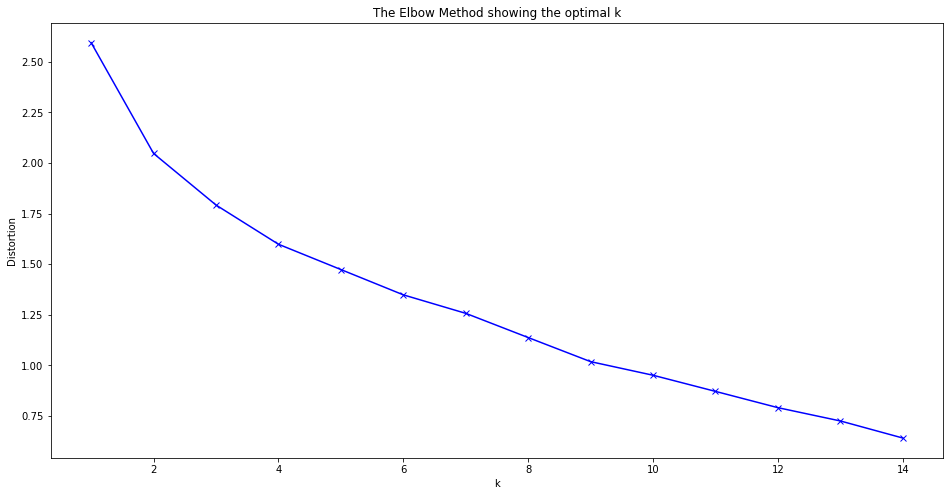

In [154]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()  

  <p> Not much of an elbow in this case... we will stick with k=5 since it was the same used in previous exercises </p>

In [155]:
kclusters =5;
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering);

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 2], dtype=int32)

<p> Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood. </p>

In [177]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_Toronto
toronto_merged= toronto_merged.rename(columns={"Neighbourhood": "Neighborhood"})
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,4,Coffee Shop,Bakery,Park,Pub,Café,Breakfast Spot,Theater,Electronics Store,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Coffee Shop,Sushi Restaurant,Gym,Discount Store,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop,Fried Chicken Joint
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Hotel,Middle Eastern Restaurant,Japanese Restaurant,Cosmetics Shop,Italian Restaurant,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,Coffee Shop,Café,Cocktail Bar,American Restaurant,Gym,Farmers Market,Creperie,Moroccan Restaurant,Department Store,Lingerie Store
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,Asian Restaurant,Coffee Shop,Health Food Store,Trail,Pub,Dog Run,Dessert Shop,Diner,Discount Store,Distribution Center


<p> We can check the clusters in the following cell </p>

In [178]:
toronto_merged[['Postal Code', 'Borough', 'Neighborhood', 'Cluster Labels']].head()

,Postal Code,Borough,Neighborhood,Cluster Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",4
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4
2,M5B,Downtown Toronto,"Garden District, Ryerson",4
3,M5C,Downtown Toronto,St. James Town,4
4,M4E,East Toronto,The Beaches,4


<p> Finally, let's visualize the resulting clusters </p>

In [179]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3> So apparently there is some error in importing folium... the code is correct so place take it into account! </h3>